## Goal of this notebook is to look at whether LDA can generate multiple topics from news articles about TESLA. After we preprocess, a baseline LDA model will be created. Then, we will see if hyper parametrization improves performance by lookin at coherence score and human judgement

In [66]:
import glob
import gensim
import nltk
import pandas as pd
from grid import utils as ut
from grid import GridSearch as gs
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from gensim import models
from tqdm import tqdm
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import seaborn as sns

In [110]:

def files_append(url):
    """
    append data from multiple csvs into one csv
    """
    data = []
    for filepath in glob.iglob(url, recursive=True):
        data.append(pd.read_csv(filepath, index_col=0))
        return pd.concat(data)

def text(data_frame, column):
    df = pd.DataFrame(data_frame[column]).dropna()
    df.columns = ['text']
    return df

def lem_stem(text):
    """
    lemmatize and stemm
    """
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    return porter.stem(lemmatizer.lemmatize(text, pos='v'))

def preprocess(text, stopwords):
    # remove stopwords and greater length 3
    text_df = [lem_stem(t.lower()) for t in text if t.lower() not in stopwords and len(t) > 3]
    return text_df


In [125]:
#stopwords
stopw = ['elon', 'musk', 'tesla', 'tsla','model','spacex','space','roadster', '(', ')', '$', 'vs.', 'co.', 'llc', '‘', '’', '“', '”', '--', "'"] + \
    list(gensim.parsing.preprocessing.STOPWORDS) + list(string.punctuation)



In [126]:
#read in files from directory and append
tesla = files_append('.\Desktop\Projects\LDA\Data\*.csv')
text_df = text(tesla,'title')
text_df['index'] = text_df.index


<>:2: DeprecationWarning: invalid escape sequence \D
<>:2: DeprecationWarning: invalid escape sequence \D
<>:2: DeprecationWarning: invalid escape sequence \D
<ipython-input-126-649f51d2ebfc>:2: DeprecationWarning: invalid escape sequence \D
  tesla = files_append('.\Desktop\Projects\LDA\Data\*.csv')


# 1. TESLA News Articles in 2018

In [127]:
tesla.head()

,author,body_sentiment_pol,body_sentiment_score,characters_count,published.date,sentences_count,source.name,title,title_sentiment_pol,title_sentiment_score
0,Chelsea Gohd,negative,0.940399,2325,2018-03-10 16:36:07+00:00,19,Futurism,"Elon Musk says hyperloop will put pedestrians,...",neutral,0.963290
1,David Z. Morris,negative,0.750187,2228,2018-03-10 15:51:55+00:00,16,Fortune,Elon Musk's Boring Company is Pivoting To Focu...,negative,0.875677
2,Editordavid,negative,0.616712,647,2018-03-10 15:35:31+00:00,5,Slashdot,Elon Musk Changes 'Boring Company' Vision To R...,negative,0.590875
3,Mandy Boone,positive,0.486549,4618,2018-03-10 15:27:42+00:00,38,Stock News Times,Tesla Inc (NASDAQ:TSLA) Shares Bought by Toron...,neutral,0.934615
4,Xavier Holt,positive,0.821998,4014,2018-03-10 14:23:52+00:00,31,Dispatch Tribunal,Tesla (NASDAQ:TSLA) vs. Kandi Technologies Gro...,neutral,0.949705


# 2. PREPROCESS

In [128]:
word = []
#tokenize the data
for s in text_df.text:
    word.append(nltk.word_tokenize(s))

# apply preprocessing: lemmatize and lower
proces_doc = list(map(lambda x: preprocess(x, stopw), word))

In [129]:
#process doc
proces_doc[:5]

[['say', 'hyperloop', 'pedestrian', 'mass', 'transit'],
 ['bore', 'compani', 'pivot', 'focu', 'move', 'pedestrian'],
 ['chang',
  "'bore",
  'compani',
  'vision',
  'reward',
  'cyclist',
  'pedestrian',
  'slashdot'],
 ['nasdaq', 'share', 'buy', 'toronto', 'dominion', 'bank'],
 ['nasdaq', 'kandi', 'technolog', 'group', 'kndi', 'critic', 'survey']]

In [131]:
#convert to dictionary
dictionary = gensim.corpora.Dictionary(proces_doc)
#filter extremes
dictionary.filter_extremes(no_below=2, no_above=1, keep_n=100000)

In [132]:
bow_corpus = [dictionary.doc2bow(doc) for doc in proces_doc]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [133]:
bow_corpus[:5]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(2, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(2, 1), (6, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)],
 [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [(18, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]]

# 3. LDA Basic Model

In [152]:
#list params in a dictionary
dicts_lda_base = {'num_topics': list(range(1,10))}

# make list of dicts
dict_conv_base = ut.param_dict_convert(dicts_lda_base)
dict_update_base = ut.param_dict_convert(dicts_lda_base)

In [63]:
dict_conv_base

[{'num_topics': 1},
 {'num_topics': 2},
 {'num_topics': 3},
 {'num_topics': 4},
 {'num_topics': 5},
 {'num_topics': 6},
 {'num_topics': 7},
 {'num_topics': 8},
 {'num_topics': 9}]

In [153]:
with tqdm(total=len(dict_update_base)) as pbar:
    for x in dict_update_base:
        x['coherence'] = gs.GridSearch(bow_corpus, dictionary, x).get_coherence_score('lda-multicore', proces_doc, 'u_mass')
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.51s/it]


In [154]:
output = ut.convert_coherence_df(dict_update_base).reset_index()
output.head()

,index,coherence,num_topics
0,1,-10.418527,2
1,2,-11.623182,3
2,0,-11.973809,1
3,5,-12.102552,6
4,7,-12.540774,8


#### Topic Num 2 has the highest coherence!

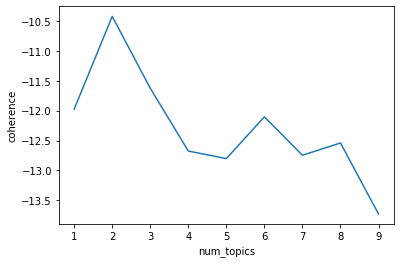

In [155]:
sns.lineplot(x="num_topics", y="coherence", data= output)

In [159]:
lda_model = gs.GridSearch(bow_corpus, dictionary, dict_conv_base[1]).nlp_model('lda-multicore')
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"falcon" + 0.015*"launch" + 0.014*"say" + 0.014*"rocket" + 0.012*"heavi" + 0.011*"product" + 0.008*"mar" + 0.008*"plan" + 0.007*"delay" + 0.007*"sell"
Topic: 1 
Words: 0.026*"launch" + 0.023*"flamethrow" + 0.016*"heavi" + 0.015*"sell" + 0.014*"falcon" + 0.013*"bore" + 0.012*"compani" + 0.012*"rocket" + 0.007*"mar" + 0.006*"electr"


In [157]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
LDAvis_prepared

C:\Users\daniela.kutleva\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.034385  0.0       1        1  51.688595
0     -0.034385  0.0       2        1  48.311413, topic_info=     Category        Freq        Term       Total  loglift  logprob
490   Default  247.000000      falcon  247.000000  30.0000  30.0000
5     Default  128.000000        bore  128.000000  29.0000  29.0000
29    Default  343.000000      launch  343.000000  28.0000  28.0000
565   Default  237.000000       heavi  237.000000  27.0000  27.0000
182   Default  131.000000         mar  131.000000  26.0000  26.0000
98    Default   62.000000        semi   62.000000  25.0000  25.0000
320   Default   50.000000        sale   50.000000  24.0000  24.0000
6     Default  144.000000     compani  144.000000  23.0000  23.0000
50    Default   49.000000        like   49.000000  22.0000  22.0000
70    Default   25.000000       dream   25.000000  21.0000  21.0000
538   Default   96.000000       delay   96.000000  20.0000  20.0000
857   Default   27.000000       today   27.000000  19.0000  19.0000
66    Default  107.000000        plan  107.000000  18.0000  18.0000
365   Default   38.000000        head   38.000000  17.0000  17.0000
289   Default   30.000000     biggest   30.000000  16.0000  16.0000
27    Default   57.000000         get   57.000000  15.0000  15.0000
171   Default   28.000000      review   28.000000  14.0000  14.0000
546   Default   68.000000       world   68.000000  13.0000  13.0000
435   Default   37.000000      reveal   37.000000  12.0000  12.0000
223   Default   30.000000        spot   30.000000  11.0000  11.0000
324   Default   28.000000       think   28.000000  10.0000  10.0000
603   Default   28.000000       shoot   28.000000   9.0000   9.0000
26    Default   49.000000   technolog   49.000000   8.0000   8.0000
284   Default   21.000000        grow   21.000000   7.0000   7.0000
578   Default   20.000000       human   20.000000   6.0000   6.0000
54    Default   39.000000       trade   39.000000   5.0000   5.0000
150   Default   30.000000       chief   30.000000   4.0000   4.0000
732   Default   18.000000       break   18.000000   3.0000   3.0000
177   Default   52.000000     billion   52.000000   2.0000   2.0000
379   Default   48.000000     batteri   48.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
165    Topic2   39.678329       stock   60.603355   0.3040  -5.3212
116    Topic2   21.707479        post   29.828293   0.4097  -5.9244
195    Topic2   34.330437       truck   51.554001   0.3209  -5.4660
22     Topic2   40.513702       group   63.331757   0.2808  -5.3004
343    Topic2   24.269493      market   34.354988   0.3800  -5.8128
541    Topic2   27.218863       amber   39.784096   0.3479  -5.6981
30     Topic2  105.397270      rocket  211.992386   0.0287  -4.3443
559    Topic2   20.420107       charg   28.020327   0.4111  -5.9855
44     Topic2   93.629189        sell  190.267822   0.0184  -4.4627
276    Topic2   28.790731        make   43.415054   0.3167  -5.6420
716    Topic2   26.894890     starman   39.790062   0.3358  -5.7101
194    Topic2   45.556667      electr   79.664307   0.1686  -5.1831
219    Topic2   67.367561     product  134.994202   0.0324  -4.7919
1025   Topic2  109.185501  flamethrow  258.374329  -0.1339  -4.3090
3      Topic2   76.120239         say  164.037109  -0.0403  -4.6697
100    Topic2   34.632427        test   56.103168   0.2451  -5.4573
694    Topic2   45.056576       earth   86.956360   0.0700  -5.1941
46     Topic2   36.878529         car   64.275803   0.1719  -5.3944
348    Topic2   41.087311       watch   76.981087   0.0996  -5.2863
105    Topic2   38.894150       power   71.538574   0.1181  -5.3412
29     Topic2   98.776642      launch  343.195892  -0.5179  -4.4092
410    Topic2   29.383810       solar   46.140205   0.2763  -5.6216
48     Topic2   36.648739       china   74.292267   0.0209  -5.4007
565    Topic2   62.30

In [161]:
lda_model_2 = gs.GridSearch(bow_corpus, dictionary, dict_conv_base[2]).nlp_model('lda-multicore')
for idx, topic in lda_model_2.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.031*"launch" + 0.024*"falcon" + 0.023*"heavi" + 0.023*"rocket" + 0.022*"sell" + 0.018*"flamethrow" + 0.013*"product" + 0.013*"say" + 0.009*"mar" + 0.009*"bore"
Topic: 1 
Words: 0.020*"flamethrow" + 0.012*"compani" + 0.010*"plan" + 0.010*"product" + 0.009*"say" + 0.009*"year" + 0.009*"launch" + 0.007*"loss" + 0.007*"bore" + 0.007*"group"
Topic: 2 
Words: 0.017*"launch" + 0.014*"falcon" + 0.013*"heavi" + 0.010*"mar" + 0.009*"trump" + 0.008*"rocket" + 0.008*"flamethrow" + 0.008*"power" + 0.008*"compani" + 0.008*"plan"


In [162]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_2, bow_corpus, dictionary)
LDAvis_prepared

C:\Users\daniela.kutleva\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.079186  0.037650       1        1  40.448795
2     -0.002928 -0.079811       2        1  33.124298
1     -0.076258  0.042161       3        1  26.426908, topic_info=     Category        Freq        Term       Total  loglift  logprob
490   Default  243.000000      falcon  243.000000  30.0000  30.0000
30    Default  210.000000      rocket  210.000000  29.0000  29.0000
565   Default  234.000000       heavi  234.000000  28.0000  28.0000
44    Default  190.000000        sell  190.000000  27.0000  27.0000
219   Default  136.000000     product  136.000000  26.0000  26.0000
186   Default   63.000000        year   63.000000  25.0000  25.0000
22    Default   63.000000       group   63.000000  24.0000  24.0000
1025  Default  260.000000  flamethrow  260.000000  23.0000  23.0000
1111  Default   34.000000    'starman   34.000000  22.0000  22.0000
367   Default   65.000000     million   65.000000  21.0000  21.0000
105   Default   69.000000       power   69.000000  20.0000  20.0000
23    Default   46.000000       kandi   46.000000  19.0000  19.0000
24    Default   46.000000        kndi   46.000000  18.0000  18.0000
1211  Default   57.000000        loss   57.000000  17.0000  17.0000
66    Default  108.000000        plan  108.000000  16.0000  16.0000
54    Default   37.000000       trade   37.000000  15.0000  15.0000
171   Default   29.000000      review   29.000000  14.0000  14.0000
26    Default   49.000000   technolog   49.000000  13.0000  13.0000
225   Default   20.000000       posit   20.000000  12.0000  12.0000
29    Default  340.000000      launch  340.000000  11.0000  11.0000
246   Default   35.000000       thing   35.000000  10.0000  10.0000
99    Default   44.000000        tech   44.000000   9.0000   9.0000
334   Default   39.000000        earn   39.000000   8.0000   8.0000
339   Default   59.000000        send   59.000000   7.0000   7.0000
18    Default   78.000000      nasdaq   78.000000   6.0000   6.0000
318   Default   35.000000      expect   35.000000   5.0000   5.0000
452   Default   20.000000     perform   20.000000   4.0000   4.0000
542   Default   41.000000        hear   41.000000   3.0000   3.0000
913   Default   27.000000        know   27.000000   2.0000   2.0000
1261  Default   28.000000        belt   28.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
169    Topic3   16.241800         hit   25.906097   0.8639  -5.6112
334    Topic3   22.577991        earn   39.566467   0.7698  -5.2818
1025   Topic3   90.407990  flamethrow  260.758850   0.2715  -3.8944
21     Topic3    8.381207      critic   11.241585   1.0372  -6.2728
339    Topic3   29.313148        send   59.918953   0.6158  -5.0207
66     Topic3   44.950447        plan  108.322701   0.4512  -4.5932
603    Topic3   16.783772       shoot   28.739414   0.7929  -5.5784
22     Topic3   29.871695       group   63.674301   0.5739  -5.0019
6      Topic3   53.530857     compani  144.932953   0.3348  -4.4185
367    Topic3   29.651562     million   65.652634   0.5359  -5.0092
99     Topic3   22.152420        tech   44.727615   0.6281  -5.3008
927    Topic3   10.594411        bezo   15.838521   0.9287  -6.0384
219    Topic3   42.954281     product  136.858017   0.1720  -4.6386
591    Topic3   22.829725      report   52.154449   0.5046  -5.2707
913    Topic3   15.096214        know   27.871822   0.7176  -5.6843
86     Topic3   17.384106     compens   36.548447   0.5877  -5.5432
289    Topic3   15.770821     biggest   31.299915   0.6453  -5.6406
3      Topic3   40.896801         say  164.539322  -0.0613  -4.6877
538    Topic3   28.755615       delay   96.747208   0.1175  -5.0399
5      Topic3   32.248966        bore  128.000534  -0.0478  -4.9253
23     Topic3   19.078918       kandi   46.983368   0.4296  -5.4502
24     Topic3   18.385248        kndi   46.929626   0.3937  -5.4872
19     Topic3  

# 4. Model Hyperparametrization LDA

In [163]:
#list params in a dictionary
dicts_lda = {'num_topics': [3], 'decay': [0.5, 0.8, 0.9], 'alpha': [0.01, 0.15, 0.25, 0.31]}

# make list of dicts
dict_conv = ut.param_dict_convert(dicts_lda)
dict_update = ut.param_dict_convert(dicts_lda)

In [164]:
#make
dict_conv[:5]

[{'num_topics': 3, 'decay': 0.5, 'alpha': 0.01},
 {'num_topics': 3, 'decay': 0.5, 'alpha': 0.15},
 {'num_topics': 3, 'decay': 0.5, 'alpha': 0.25},
 {'num_topics': 3, 'decay': 0.5, 'alpha': 0.31},
 {'num_topics': 3, 'decay': 0.8, 'alpha': 0.01}]

In [165]:
with tqdm(total=len(dict_update)) as pbar:
    for x in dict_update:
        x['coherence'] = gs.GridSearch(bow_corpus, dictionary, x).get_coherence_score('lda-multicore', proces_doc, 'u_mass')
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:55<00:00,  4.75s/it]


In [166]:
dict_conv[:5]

[{'num_topics': 3, 'decay': 0.5, 'alpha': 0.01},
 {'num_topics': 3, 'decay': 0.5, 'alpha': 0.15},
 {'num_topics': 3, 'decay': 0.5, 'alpha': 0.25},
 {'num_topics': 3, 'decay': 0.5, 'alpha': 0.31},
 {'num_topics': 3, 'decay': 0.8, 'alpha': 0.01}]

In [167]:
#convert to df and sort by highest coherence
ut.convert_coherence_df(dict_update).reset_index()[:5]
#parameter 

,index,alpha,coherence,decay,num_topics
0,5,0.15,-11.705748,0.8,3
1,1,0.15,-11.869271,0.5,3
2,2,0.25,-11.891029,0.5,3
3,4,0.01,-11.910041,0.8,3
4,7,0.31,-11.995798,0.8,3


In [168]:
lda_model = gs.GridSearch(bow_corpus, dictionary, dict_conv[5]).nlp_model('lda')
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.048*"flamethrow" + 0.016*"sell" + 0.014*"say" + 0.012*"product" + 0.009*"hear" + 0.009*"amber" + 0.009*"compani" + 0.008*"parti" + 0.008*"stock" + 0.007*"goal"
Topic: 1 
Words: 0.035*"launch" + 0.031*"falcon" + 0.029*"heavi" + 0.025*"rocket" + 0.012*"mar" + 0.012*"say" + 0.011*"flamethrow" + 0.011*"sell" + 0.010*"power" + 0.009*"world"
Topic: 2 
Words: 0.023*"bore" + 0.019*"compani" + 0.017*"sell" + 0.012*"launch" + 0.009*"product" + 0.009*"million" + 0.009*"plan" + 0.008*"home" + 0.007*"like" + 0.007*"day"


In [169]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
LDAvis_prepared

C:\Users\daniela.kutleva\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.038036 -0.117305       1        1  37.360008
0     -0.139011  0.030765       2        1  32.456837
2      0.100976  0.086540       3        1  30.183163, topic_info=     Category        Freq        Term       Total  loglift  logprob
1025  Default  330.000000  flamethrow  330.000000  30.0000  30.0000
490   Default  231.000000      falcon  231.000000  29.0000  29.0000
565   Default  220.000000       heavi  220.000000  28.0000  28.0000
5     Default  155.000000        bore  155.000000  27.0000  27.0000
29    Default  310.000000      launch  310.000000  26.0000  26.0000
30    Default  196.000000      rocket  196.000000  25.0000  25.0000
542   Default   51.000000        hear   51.000000  24.0000  24.0000
541   Default   49.000000       amber   49.000000  23.0000  23.0000
105   Default   75.000000       power   75.000000  22.0000  22.0000
288   Default   38.000000         day   38.000000  21.0000  21.0000
1310  Default   43.000000       worth   43.000000  20.0000  20.0000
442   Default   44.000000        home   44.000000  19.0000  19.0000
6     Default  171.000000     compani  171.000000  18.0000  18.0000
543   Default   54.000000       parti   54.000000  17.0000  17.0000
317   Default   28.000000     announc   28.000000  16.0000  16.0000
165   Default   55.000000       stock   55.000000  15.0000  15.0000
277   Default   38.000000     station   38.000000  14.0000  14.0000
228   Default   27.000000  california   27.000000  13.0000  13.0000
1003  Default   57.000000        goal   57.000000  12.0000  12.0000
694   Default   67.000000       earth   67.000000  11.0000  11.0000
391   Default   28.000000        meet   28.000000  10.0000  10.0000
68    Default   38.000000      tunnel   38.000000   9.0000   9.0000
72    Default   45.000000      packag   45.000000   8.0000   8.0000
546   Default   70.000000       world   70.000000   7.0000   7.0000
50    Default   52.000000        like   52.000000   6.0000   6.0000
320   Default   51.000000        sale   51.000000   5.0000   5.0000
463   Default   22.000000      10,000   22.000000   4.0000   4.0000
18    Default   61.000000      nasdaq   61.000000   3.0000   3.0000
750   Default   22.000000     silicon   22.000000   2.0000   2.0000
388   Default   44.000000        time   44.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
302    Topic3   13.916449      driver   16.977102   0.9991  -5.8986
1207   Topic3   14.751230    showroom   18.146536   0.9907  -5.8403
50     Topic3   36.742123        like   52.395382   0.8430  -4.9277
6      Topic3   95.511986     compani  171.380081   0.6133  -3.9724
435    Topic3   25.035845      reveal   35.314125   0.8539  -5.3114
1416   Topic3   13.859471       south   17.037901   0.9914  -5.9027
367    Topic3   44.097954     million   71.785881   0.7106  -4.7453
171    Topic3   18.760954      review   25.045477   0.9090  -5.5999
1304   Topic3   17.517807     quarter   22.961910   0.9273  -5.6684
261    Topic3   17.934528        work   23.754095   0.9169  -5.6449
18     Topic3   36.515011      nasdaq   61.367702   0.6787  -4.9339
379    Topic3   32.697765     batteri   55.203770   0.6742  -5.0444
410    Topic3   30.712608       solar   53.651840   0.6400  -5.1070
44     Topic3   84.976395        sell  237.642288   0.1695  -4.0893
377    Topic3   34.864311      target   71.720505   0.4766  -4.9802
37     Topic3   28.442406       video   55.193016   0.5349  -5.1838
66     Topic3   44.089626        plan  120.828979   0.1897  -4.7454
219    Topic3   46.126457     product  146.565308   0.0418  -4.7003
268    Topic3   21.530750        deal   37.164253   0.6520  -5.4622
371    Topic3   22.573755        come   41.001095   0.6011  -5.4149
29     Topic3   60.740314      launch  310.794281  -0.4346  -4.4251
19     Topic3   25.126120       share   56.155479   0.3937  -5.3078
194    Topic3  